### Import libraries

In [5]:
# libraries
import os
import cv2
import sys
import keras
import tarfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.engine.training import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.applications import VGG16
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

### Mount Google Drive

In [6]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
#BASEPATH = "/content/gdrive/MyDrive/dogs_vs_cats/Images"
BASEPATH = "/content/gdrive/MyDrive/MDST/dogs-vs-cats/Images"

### Data Preprocessing

In [8]:
from keras.utils import image_dataset
import cv2

LABELS = set()
paths = []
for d in os.listdir(BASEPATH):
  LABELS.add(d)
  paths.append((BASEPATH + '/' + d, d))

# resizing and converting to RGB
def load_and_preprocess_image(path):
  image = cv2.imread(path)
  image = cv2.resize(image, (80, 80))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  return image

X, y = [], []
i = 0
for path, label in paths:
  i += 1
  # if path == '/content/gdrive/MyDrive/dogs_vs_cats/Images/.DS_Store': continue
  if path == "/content/gdrive/MyDrive/MDST/dogs-vs-cats/Images": continue

  for image_path in os.listdir(path):
    image = load_and_preprocess_image(path + "/" + image_path)
    X.append(image)
    y.append(label)

Y = []

# cleaning the names of the directories/targets
for i in y:
  Y.append(i.split('-')[1])

# Checking for accurate labels and pictures

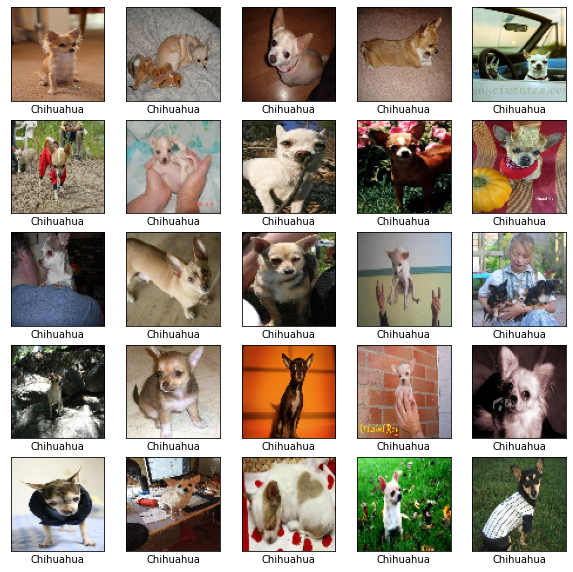

In [9]:
plt.figure(figsize=(10,10))

for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(X[i], cmap="gray")
  plt.xlabel(Y[i])
plt.show()

# Label Binarizer

In [10]:
encoder = LabelBinarizer()
X = np.array(X)
y = encoder.fit_transform(np.array(y))

# Splitting Data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Building VGG-16

In [12]:
model = Sequential()

model.add(Conv2D(64,(3,3),activation="relu", padding="same"))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3),activation="relu", padding="same"))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3),activation="relu", padding="same"))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(128,(3,3),activation="relu", padding="same"))
model.add(MaxPooling2D())

model.add(Conv2D(128,(3,3),activation="relu", padding="same"))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(1024,activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(256,activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(120,activation="softmax"))

In [13]:
base_model=VGG16(weights='imagenet',include_top=False)

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
x=Dense(1024,activation='relu')(x)
x=Dropout(0.5)(x)
x=Dense(512,activation='relu')(x)
preds=Dense(len(LABELS),activation='softmax')(x)

model=Model(inputs=base_model.input,outputs=preds)

for layer in model.layers[:-5]:
    layer.trainable=False
for layer in model.layers[-5:]:
    layer.trainable=True
    
model.compile("adam",loss="categorical_crossentropy",metrics=["accuracy"])

print(model.summary())

58889256/58889256 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

### Model compilation

In [14]:
early_stopping = EarlyStopping(patience=5, verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=3,verbose=1)

In [15]:
model.fit(X_train,y_train,batch_size=64,epochs=50,validation_data=(X_test,y_test), callbacks=[early_stopping, reduce_lr])

Epoch 1/50
242/242 [==============================] - 25s 67ms/step - loss: 5.3008 - accuracy: 0.0427 - val_loss: 4.1462 - val_accuracy: 0.0962 - lr: 0.0010
Epoch 2/50
242/242 [==============================] - 15s 63ms/step - loss: 4.0084 - accuracy: 0.1103 - val_loss: 3.8519 - val_accuracy: 0.1298 - lr: 0.0010
Epoch 3/50
242/242 [==============================] - 16s 64ms/step - loss: 3.6673 - accuracy: 0.1559 - val_loss: 3.7092 - val_accuracy: 0.1481 - lr: 0.0010
Epoch 4/50
242/242 [==============================] - 16s 66ms/step - loss: 3.4037 - accuracy: 0.1979 - val_loss: 3.5907 - val_accuracy: 0.1638 - lr: 0.0010
Epoch 5/50
242/242 [==============================] - 16s 67ms/step - loss: 3.1685 - accuracy: 0.2288 - val_loss: 3.5804 - val_accuracy: 0.1790 - lr: 0.0010
Epoch 6/50
242/242 [==============================] - 16s 66ms/step - loss: 2.9345 - accuracy: 0.2757 - val_loss: 3.5520 - val_accuracy: 0.1846 - lr: 0.0010
Epoch 7/50
242/242 [==============================] - 16s 

1/1 [==============================] - 1s 936ms/step


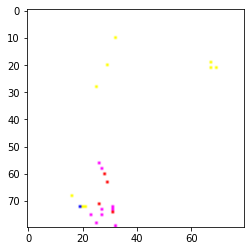

'n02086910-papillon'

In [19]:
testpath = '/content/gdrive/MyDrive/MDST/dogs-vs-cats/user_test/morgan_english_cocker_spaniel.jpg'

def runprediction(imgpath):
  X = []
  image = load_and_preprocess_image(imgpath)
  X.append(image)
  X = np.array(X)
  tempx = X.astype("float32")
  prediction = model.predict(tempx)
  temp = prediction[0]
  temp[np.argmax(temp)] = 1
  prediction = np.floor(temp).astype(int)
  plt.imshow(tempx[0], cmap=plt.get_cmap('gray'))
  plt.show()
  return encoder.inverse_transform(np.array([prediction]))[0]

runprediction(testpath)